In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2526912378143898413, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17457366352197989529
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5276092160387258607
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2889716945418027675
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [0]:
! git clone https://github.com/MyGreenSlime/Deeplearning_finalproject.git

fatal: destination path 'Deeplearning_finalproject' already exists and is not an empty directory.


In [0]:
import os
from glob import glob

WEIGHTS_FOLDER = './weights/'
DATA_FOLDER = './data/'

if not os.path.exists(WEIGHTS_FOLDER):
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))


### Imports

In [0]:
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model

Using TensorFlow backend.


###Data

In [0]:
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 63565


In [0]:
INPUT_DIM = (64,64,3) # Image dimension
BATCH_SIZE = 32
Z_DIM = 100 # Dimension of the latent vector (z)

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, 
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training'
                                                                   )

Found 63565 images belonging to 1 classes.


In [0]:
import matplotlib.pyplot as plt

## VARIATIONAL AUTOENCODER



In [0]:
# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, 
                  conv_strides, use_batch_norm = False, use_dropout = False):
  
  # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
  # BatchNormalization and Dropout.
  # Otherwise, the names of above mentioned layers in the model 
  # would be inconsistent
  global K
  K.clear_session()
  
  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2D(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)
      if use_batch_norm:
        x = BathcNormalization()(x)
  
      x = LeakyReLU()(x)

      if use_dropout:
        x = Dropout(rate=0.25)(x)

  # Required for reshaping latent vector while building Decoder
  shape_before_flattening = K.int_shape(x)[1:] 
  
  x = Flatten()(x)
  
  mean_mu = Dense(output_dim, name = 'mu')(x)
  log_var = Dense(output_dim, name = 'log_var')(x)

  # Defining a function for sampling
  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon   
  
  # Using a Keras Lambda Layer to include the sampling function as a layer 
  # in the model
  encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])

  return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)

In [0]:
# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):

  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

  # To get an exact mirror image of the encoder
  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2DTranspose(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'decoder_conv_' + str(i)
                  )(x)
      
      # Adding a sigmoid layer at the end to restrict the outputs 
      # between 0 and 1
      if i < n_layers - 1:
        x = LeakyReLU()(x)
      else:
        x = Activation('sigmoid')(x)

  # Define model output
  decoder_output = x

  return decoder_input, decoder_output, Model(decoder_input, decoder_output)

In [0]:
vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

vae_encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 32, 32, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 32, 32, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 16, 16, 64)   18496       leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

In [0]:
vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = vae_shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )
vae_decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              103424    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
decoder_conv_0 (Conv2DTransp (None, 8, 8, 64)          36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 64)        0   

#### Attaching the Decoder to the Encoder


In [0]:
# The input to the model will be the image fed to the encoder.
vae_input = vae_encoder_input

# Output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
vae_output = vae_decoder(vae_encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
vae_model = Model(vae_input, vae_output)

vae_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 32, 32, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 32, 32, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 16, 16, 64)   18496       leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

### COMPILATION AND TRAINING


In [0]:
LEARNING_RATE = 0.0005
N_EPOCHS = 200
LOSS_FACTOR = 10000

In [0]:
def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    
def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

def vae_generate_images(n_to_show=10):
  reconst_images = vae_decoder.predict(np.random.normal(0,1,size=(n_to_show,Z_DIM)))

  fig = plt.figure(figsize=(10, 10))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img)
  plt.show()

In [0]:
adam_optimizer = Adam(lr = LEARNING_RATE)

vae_model.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])

checkpoint_vae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/weights.h5'), save_weights_only = True, verbose=1)

Epoch 1/10
1987/1986 [==============================] - 43s 22ms/step - loss: 396.8032 - r_loss: 0.0353 - kl_loss: 43.8197

Epoch 00001: saving model to ./weights/VAE/weights.h5
Epoch 2/10
1987/1986 [==============================] - 41s 21ms/step - loss: 328.1328 - r_loss: 0.0277 - kl_loss: 50.9606

Epoch 00002: saving model to ./weights/VAE/weights.h5
Epoch 3/10
1987/1986 [==============================] - 41s 21ms/step - loss: 319.2756 - r_loss: 0.0265 - kl_loss: 53.9866

Epoch 00003: saving model to ./weights/VAE/weights.h5
Epoch 4/10
1987/1986 [==============================] - 41s 21ms/step - loss: 313.0923 - r_loss: 0.0257 - kl_loss: 56.3311

Epoch 00004: saving model to ./weights/VAE/weights.h5
Epoch 5/10
1987/1986 [==============================] - 41s 21ms/step - loss: 307.3273 - r_loss: 0.0249 - kl_loss: 58.3770

Epoch 00005: saving model to ./weights/VAE/weights.h5
Epoch 6/10
1987/1986 [==============================] - 41s 21ms/step - loss: 304.9461 - r_loss: 0.0246 - kl_l

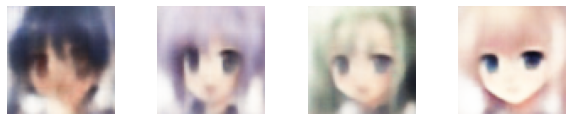

Epoch 11/20
1987/1986 [==============================] - 41s 21ms/step - loss: 299.3639 - r_loss: 0.0238 - kl_loss: 60.9080

Epoch 00011: saving model to ./weights/VAE/weights.h5
Epoch 12/20
1987/1986 [==============================] - 41s 21ms/step - loss: 298.8254 - r_loss: 0.0238 - kl_loss: 61.1487

Epoch 00012: saving model to ./weights/VAE/weights.h5
Epoch 13/20
1987/1986 [==============================] - 41s 21ms/step - loss: 298.3395 - r_loss: 0.0237 - kl_loss: 61.3478

Epoch 00013: saving model to ./weights/VAE/weights.h5
Epoch 14/20
1987/1986 [==============================] - 41s 21ms/step - loss: 297.8618 - r_loss: 0.0236 - kl_loss: 61.5214

Epoch 00014: saving model to ./weights/VAE/weights.h5
Epoch 15/20
1987/1986 [==============================] - 41s 21ms/step - loss: 297.4294 - r_loss: 0.0236 - kl_loss: 61.7119

Epoch 00015: saving model to ./weights/VAE/weights.h5
Epoch 16/20
1987/1986 [==============================] - 41s 21ms/step - loss: 297.1221 - r_loss: 0.0235 

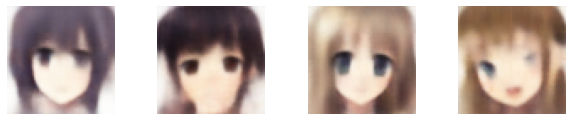

Epoch 21/30
1987/1986 [==============================] - 41s 20ms/step - loss: 295.6401 - r_loss: 0.0233 - kl_loss: 62.2844

Epoch 00021: saving model to ./weights/VAE/weights.h5
Epoch 22/30
1987/1986 [==============================] - 41s 21ms/step - loss: 295.5003 - r_loss: 0.0233 - kl_loss: 62.4091

Epoch 00022: saving model to ./weights/VAE/weights.h5
Epoch 23/30
1987/1986 [==============================] - 41s 21ms/step - loss: 295.2528 - r_loss: 0.0233 - kl_loss: 62.4627

Epoch 00023: saving model to ./weights/VAE/weights.h5
Epoch 24/30
1987/1986 [==============================] - 41s 21ms/step - loss: 295.0455 - r_loss: 0.0233 - kl_loss: 62.4939

Epoch 00024: saving model to ./weights/VAE/weights.h5
Epoch 25/30
1987/1986 [==============================] - 41s 21ms/step - loss: 294.8888 - r_loss: 0.0232 - kl_loss: 62.5663

Epoch 00025: saving model to ./weights/VAE/weights.h5
Epoch 26/30
1987/1986 [==============================] - 41s 21ms/step - loss: 294.7100 - r_loss: 0.0232 

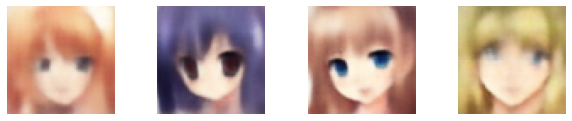

Epoch 31/40
1987/1986 [==============================] - 41s 21ms/step - loss: 293.9329 - r_loss: 0.0231 - kl_loss: 62.7898

Epoch 00031: saving model to ./weights/VAE/weights.h5
Epoch 32/40
1987/1986 [==============================] - 41s 21ms/step - loss: 293.8149 - r_loss: 0.0231 - kl_loss: 62.8656

Epoch 00032: saving model to ./weights/VAE/weights.h5
Epoch 33/40
1987/1986 [==============================] - 41s 21ms/step - loss: 293.7249 - r_loss: 0.0231 - kl_loss: 62.8962

Epoch 00033: saving model to ./weights/VAE/weights.h5
Epoch 34/40
1987/1986 [==============================] - 41s 21ms/step - loss: 293.6170 - r_loss: 0.0231 - kl_loss: 62.9166

Epoch 00034: saving model to ./weights/VAE/weights.h5
Epoch 35/40
1987/1986 [==============================] - 41s 21ms/step - loss: 293.4694 - r_loss: 0.0231 - kl_loss: 62.9173

Epoch 00035: saving model to ./weights/VAE/weights.h5
Epoch 36/40
1987/1986 [==============================] - 41s 21ms/step - loss: 293.4167 - r_loss: 0.0230 

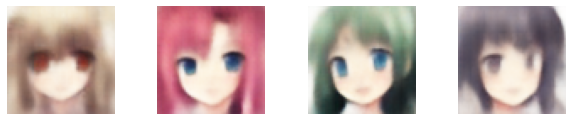

Epoch 41/50
1987/1986 [==============================] - 41s 21ms/step - loss: 292.9198 - r_loss: 0.0230 - kl_loss: 63.0622

Epoch 00041: saving model to ./weights/VAE/weights.h5
Epoch 42/50
1987/1986 [==============================] - 41s 21ms/step - loss: 292.8378 - r_loss: 0.0230 - kl_loss: 63.0964

Epoch 00042: saving model to ./weights/VAE/weights.h5
Epoch 43/50
1987/1986 [==============================] - 41s 21ms/step - loss: 292.8022 - r_loss: 0.0230 - kl_loss: 63.1116

Epoch 00043: saving model to ./weights/VAE/weights.h5
Epoch 44/50
1987/1986 [==============================] - 41s 21ms/step - loss: 292.6201 - r_loss: 0.0230 - kl_loss: 63.0657

Epoch 00044: saving model to ./weights/VAE/weights.h5
Epoch 45/50
1987/1986 [==============================] - 41s 21ms/step - loss: 292.6329 - r_loss: 0.0229 - kl_loss: 63.1304

Epoch 00045: saving model to ./weights/VAE/weights.h5
Epoch 46/50
1987/1986 [==============================] - 41s 21ms/step - loss: 292.4670 - r_loss: 0.0229 

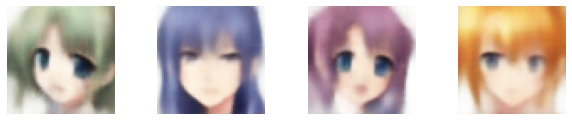

Epoch 51/60
1987/1986 [==============================] - 41s 21ms/step - loss: 292.1157 - r_loss: 0.0229 - kl_loss: 63.2012

Epoch 00051: saving model to ./weights/VAE/weights.h5
Epoch 52/60
1987/1986 [==============================] - 41s 21ms/step - loss: 292.0931 - r_loss: 0.0229 - kl_loss: 63.2435

Epoch 00052: saving model to ./weights/VAE/weights.h5
Epoch 53/60
1987/1986 [==============================] - 41s 21ms/step - loss: 292.1353 - r_loss: 0.0229 - kl_loss: 63.2692

Epoch 00053: saving model to ./weights/VAE/weights.h5
Epoch 54/60
1987/1986 [==============================] - 41s 21ms/step - loss: 291.9512 - r_loss: 0.0229 - kl_loss: 63.2130

Epoch 00054: saving model to ./weights/VAE/weights.h5
Epoch 55/60
1987/1986 [==============================] - 41s 21ms/step - loss: 291.9286 - r_loss: 0.0229 - kl_loss: 63.2856

Epoch 00055: saving model to ./weights/VAE/weights.h5
Epoch 56/60
1987/1986 [==============================] - 41s 21ms/step - loss: 291.8609 - r_loss: 0.0229 

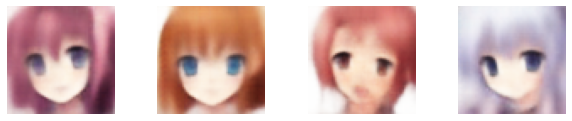

Epoch 61/70
1987/1986 [==============================] - 40s 20ms/step - loss: 291.5910 - r_loss: 0.0228 - kl_loss: 63.2929

Epoch 00061: saving model to ./weights/VAE/weights.h5
Epoch 62/70
1987/1986 [==============================] - 41s 20ms/step - loss: 291.5691 - r_loss: 0.0228 - kl_loss: 63.3475

Epoch 00062: saving model to ./weights/VAE/weights.h5
Epoch 63/70
1987/1986 [==============================] - 41s 20ms/step - loss: 291.5199 - r_loss: 0.0228 - kl_loss: 63.3689

Epoch 00063: saving model to ./weights/VAE/weights.h5
Epoch 64/70
1987/1986 [==============================] - 41s 20ms/step - loss: 291.4885 - r_loss: 0.0228 - kl_loss: 63.3636

Epoch 00064: saving model to ./weights/VAE/weights.h5
Epoch 65/70
1987/1986 [==============================] - 41s 20ms/step - loss: 291.4366 - r_loss: 0.0228 - kl_loss: 63.3582

Epoch 00065: saving model to ./weights/VAE/weights.h5
Epoch 66/70
1987/1986 [==============================] - 41s 21ms/step - loss: 291.4386 - r_loss: 0.0228 

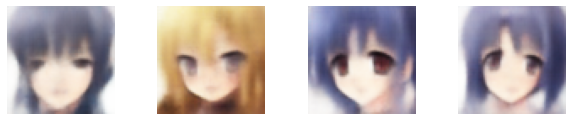

Epoch 71/80
1987/1986 [==============================] - 41s 20ms/step - loss: 291.1799 - r_loss: 0.0228 - kl_loss: 63.4065

Epoch 00071: saving model to ./weights/VAE/weights.h5
Epoch 72/80
1987/1986 [==============================] - 40s 20ms/step - loss: 291.1388 - r_loss: 0.0228 - kl_loss: 63.4573

Epoch 00072: saving model to ./weights/VAE/weights.h5
Epoch 73/80
1987/1986 [==============================] - 41s 21ms/step - loss: 291.1586 - r_loss: 0.0228 - kl_loss: 63.5188

Epoch 00073: saving model to ./weights/VAE/weights.h5
Epoch 74/80
1987/1986 [==============================] - 41s 20ms/step - loss: 291.0571 - r_loss: 0.0228 - kl_loss: 63.4401

Epoch 00074: saving model to ./weights/VAE/weights.h5
Epoch 75/80
1987/1986 [==============================] - 41s 20ms/step - loss: 291.0477 - r_loss: 0.0228 - kl_loss: 63.4940

Epoch 00075: saving model to ./weights/VAE/weights.h5
Epoch 76/80
1987/1986 [==============================] - 41s 20ms/step - loss: 290.9711 - r_loss: 0.0227 

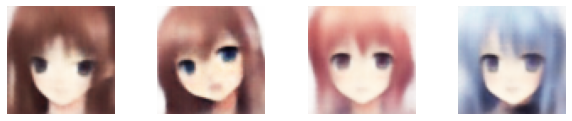

Epoch 81/90
1987/1986 [==============================] - 41s 21ms/step - loss: 290.8042 - r_loss: 0.0227 - kl_loss: 63.4639

Epoch 00081: saving model to ./weights/VAE/weights.h5
Epoch 82/90
1987/1986 [==============================] - 41s 20ms/step - loss: 290.8139 - r_loss: 0.0227 - kl_loss: 63.5211

Epoch 00082: saving model to ./weights/VAE/weights.h5
Epoch 83/90
1987/1986 [==============================] - 41s 20ms/step - loss: 290.7850 - r_loss: 0.0227 - kl_loss: 63.5284

Epoch 00083: saving model to ./weights/VAE/weights.h5
Epoch 84/90
1987/1986 [==============================] - 41s 21ms/step - loss: 290.7493 - r_loss: 0.0227 - kl_loss: 63.5564

Epoch 00084: saving model to ./weights/VAE/weights.h5
Epoch 85/90
1987/1986 [==============================] - 41s 21ms/step - loss: 290.7042 - r_loss: 0.0227 - kl_loss: 63.5175

Epoch 00085: saving model to ./weights/VAE/weights.h5
Epoch 86/90
1987/1986 [==============================] - 41s 20ms/step - loss: 290.7157 - r_loss: 0.0227 

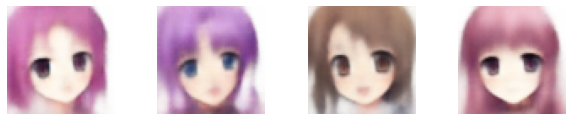

Epoch 91/100
1987/1986 [==============================] - 41s 20ms/step - loss: 290.5974 - r_loss: 0.0227 - kl_loss: 63.6054

Epoch 00091: saving model to ./weights/VAE/weights.h5
Epoch 92/100
1987/1986 [==============================] - 41s 20ms/step - loss: 290.4764 - r_loss: 0.0227 - kl_loss: 63.5457

Epoch 00092: saving model to ./weights/VAE/weights.h5
Epoch 93/100
1987/1986 [==============================] - 41s 20ms/step - loss: 290.4577 - r_loss: 0.0227 - kl_loss: 63.5641

Epoch 00093: saving model to ./weights/VAE/weights.h5
Epoch 94/100
1987/1986 [==============================] - 41s 20ms/step - loss: 290.4798 - r_loss: 0.0227 - kl_loss: 63.5409

Epoch 00094: saving model to ./weights/VAE/weights.h5
Epoch 95/100
1987/1986 [==============================] - 41s 20ms/step - loss: 290.4621 - r_loss: 0.0227 - kl_loss: 63.5743

Epoch 00095: saving model to ./weights/VAE/weights.h5
Epoch 96/100
1987/1986 [==============================] - 41s 21ms/step - loss: 290.4033 - r_loss: 0

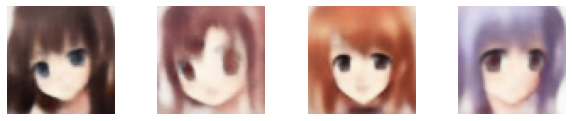

Epoch 101/110
1987/1986 [==============================] - 40s 20ms/step - loss: 290.2840 - r_loss: 0.0227 - kl_loss: 63.5896

Epoch 00101: saving model to ./weights/VAE/weights.h5
Epoch 102/110
1987/1986 [==============================] - 41s 20ms/step - loss: 290.2995 - r_loss: 0.0227 - kl_loss: 63.6252

Epoch 00102: saving model to ./weights/VAE/weights.h5
Epoch 103/110
1987/1986 [==============================] - 41s 20ms/step - loss: 290.2671 - r_loss: 0.0227 - kl_loss: 63.6205

Epoch 00103: saving model to ./weights/VAE/weights.h5
Epoch 104/110
1987/1986 [==============================] - 41s 21ms/step - loss: 290.2092 - r_loss: 0.0227 - kl_loss: 63.6255

Epoch 00104: saving model to ./weights/VAE/weights.h5
Epoch 105/110
1987/1986 [==============================] - 41s 20ms/step - loss: 290.2107 - r_loss: 0.0227 - kl_loss: 63.6435

Epoch 00105: saving model to ./weights/VAE/weights.h5
Epoch 106/110
1987/1986 [==============================] - 41s 21ms/step - loss: 290.2118 - r_l

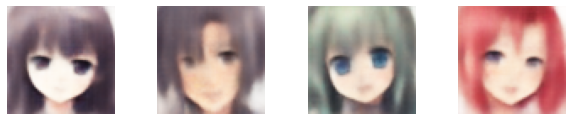

Epoch 111/120
1987/1986 [==============================] - 41s 21ms/step - loss: 290.0565 - r_loss: 0.0226 - kl_loss: 63.6431

Epoch 00111: saving model to ./weights/VAE/weights.h5
Epoch 112/120
1987/1986 [==============================] - 41s 21ms/step - loss: 290.0047 - r_loss: 0.0226 - kl_loss: 63.6036

Epoch 00112: saving model to ./weights/VAE/weights.h5
Epoch 113/120
1987/1986 [==============================] - 41s 21ms/step - loss: 290.0380 - r_loss: 0.0226 - kl_loss: 63.6552

Epoch 00113: saving model to ./weights/VAE/weights.h5
Epoch 114/120
1987/1986 [==============================] - 41s 21ms/step - loss: 289.9756 - r_loss: 0.0226 - kl_loss: 63.6400

Epoch 00114: saving model to ./weights/VAE/weights.h5
Epoch 115/120
1987/1986 [==============================] - 41s 21ms/step - loss: 290.0123 - r_loss: 0.0226 - kl_loss: 63.6316

Epoch 00115: saving model to ./weights/VAE/weights.h5
Epoch 116/120
1987/1986 [==============================] - 41s 20ms/step - loss: 289.9952 - r_l

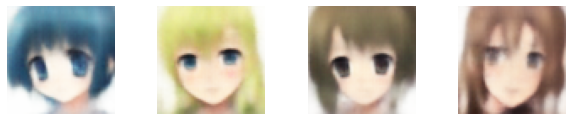

Epoch 121/130
1987/1986 [==============================] - 41s 21ms/step - loss: 289.8908 - r_loss: 0.0226 - kl_loss: 63.6850

Epoch 00121: saving model to ./weights/VAE/weights.h5
Epoch 122/130
1987/1986 [==============================] - 41s 21ms/step - loss: 289.8738 - r_loss: 0.0226 - kl_loss: 63.6791

Epoch 00122: saving model to ./weights/VAE/weights.h5
Epoch 123/130
1987/1986 [==============================] - 41s 21ms/step - loss: 289.8629 - r_loss: 0.0226 - kl_loss: 63.7055

Epoch 00123: saving model to ./weights/VAE/weights.h5
Epoch 124/130
1987/1986 [==============================] - 41s 21ms/step - loss: 289.8323 - r_loss: 0.0226 - kl_loss: 63.6899

Epoch 00124: saving model to ./weights/VAE/weights.h5
Epoch 125/130
1987/1986 [==============================] - 41s 20ms/step - loss: 289.7800 - r_loss: 0.0226 - kl_loss: 63.6613

Epoch 00125: saving model to ./weights/VAE/weights.h5
Epoch 126/130
1987/1986 [==============================] - 41s 20ms/step - loss: 289.7703 - r_l

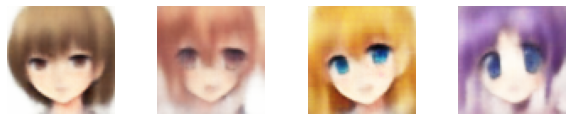

Epoch 131/140
1987/1986 [==============================] - 41s 20ms/step - loss: 289.7134 - r_loss: 0.0226 - kl_loss: 63.6903

Epoch 00131: saving model to ./weights/VAE/weights.h5
Epoch 132/140
1987/1986 [==============================] - 41s 20ms/step - loss: 289.7318 - r_loss: 0.0226 - kl_loss: 63.6992

Epoch 00132: saving model to ./weights/VAE/weights.h5
Epoch 133/140
1987/1986 [==============================] - 41s 20ms/step - loss: 289.7019 - r_loss: 0.0226 - kl_loss: 63.7298

Epoch 00133: saving model to ./weights/VAE/weights.h5
Epoch 134/140
1987/1986 [==============================] - 41s 21ms/step - loss: 289.6508 - r_loss: 0.0226 - kl_loss: 63.6897

Epoch 00134: saving model to ./weights/VAE/weights.h5
Epoch 135/140
1987/1986 [==============================] - 40s 20ms/step - loss: 289.6406 - r_loss: 0.0226 - kl_loss: 63.6933

Epoch 00135: saving model to ./weights/VAE/weights.h5
Epoch 136/140
1987/1986 [==============================] - 40s 20ms/step - loss: 289.6160 - r_l

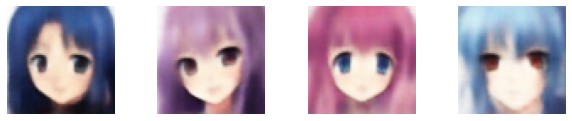

Epoch 141/150
1987/1986 [==============================] - 40s 20ms/step - loss: 289.6622 - r_loss: 0.0226 - kl_loss: 63.7269

Epoch 00141: saving model to ./weights/VAE/weights.h5
Epoch 142/150
1987/1986 [==============================] - 41s 21ms/step - loss: 289.5275 - r_loss: 0.0226 - kl_loss: 63.7077

Epoch 00142: saving model to ./weights/VAE/weights.h5
Epoch 143/150
1987/1986 [==============================] - 41s 20ms/step - loss: 289.5903 - r_loss: 0.0226 - kl_loss: 63.7544

Epoch 00143: saving model to ./weights/VAE/weights.h5
Epoch 144/150
1987/1986 [==============================] - 41s 20ms/step - loss: 289.5733 - r_loss: 0.0226 - kl_loss: 63.7641

Epoch 00144: saving model to ./weights/VAE/weights.h5
Epoch 145/150
1987/1986 [==============================] - 41s 20ms/step - loss: 289.5673 - r_loss: 0.0226 - kl_loss: 63.7523

Epoch 00145: saving model to ./weights/VAE/weights.h5
Epoch 146/150
1987/1986 [==============================] - 41s 20ms/step - loss: 289.5145 - r_l

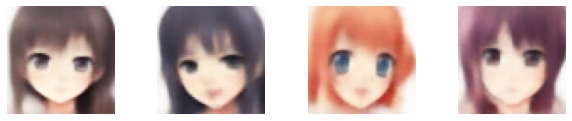

Epoch 151/160
1987/1986 [==============================] - 41s 20ms/step - loss: 289.4576 - r_loss: 0.0226 - kl_loss: 63.7378

Epoch 00151: saving model to ./weights/VAE/weights.h5
Epoch 152/160
1987/1986 [==============================] - 41s 20ms/step - loss: 289.4134 - r_loss: 0.0226 - kl_loss: 63.7267

Epoch 00152: saving model to ./weights/VAE/weights.h5
Epoch 153/160
1987/1986 [==============================] - 41s 20ms/step - loss: 289.4141 - r_loss: 0.0226 - kl_loss: 63.7492

Epoch 00153: saving model to ./weights/VAE/weights.h5
Epoch 154/160
1987/1986 [==============================] - 41s 20ms/step - loss: 289.4280 - r_loss: 0.0226 - kl_loss: 63.7674

Epoch 00154: saving model to ./weights/VAE/weights.h5
Epoch 155/160
1987/1986 [==============================] - 41s 20ms/step - loss: 289.4058 - r_loss: 0.0226 - kl_loss: 63.7690

Epoch 00155: saving model to ./weights/VAE/weights.h5
Epoch 156/160
1987/1986 [==============================] - 41s 20ms/step - loss: 289.3971 - r_l

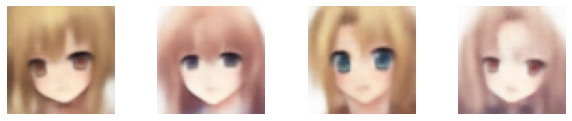

Epoch 161/170
1987/1986 [==============================] - 41s 20ms/step - loss: 289.3146 - r_loss: 0.0226 - kl_loss: 63.7729

Epoch 00161: saving model to ./weights/VAE/weights.h5
Epoch 162/170
1987/1986 [==============================] - 41s 20ms/step - loss: 289.3664 - r_loss: 0.0226 - kl_loss: 63.7772

Epoch 00162: saving model to ./weights/VAE/weights.h5
Epoch 163/170
1987/1986 [==============================] - 41s 20ms/step - loss: 289.2873 - r_loss: 0.0226 - kl_loss: 63.7864

Epoch 00163: saving model to ./weights/VAE/weights.h5
Epoch 164/170
1987/1986 [==============================] - 40s 20ms/step - loss: 289.2609 - r_loss: 0.0225 - kl_loss: 63.7518

Epoch 00164: saving model to ./weights/VAE/weights.h5
Epoch 165/170
1987/1986 [==============================] - 41s 21ms/step - loss: 289.3313 - r_loss: 0.0226 - kl_loss: 63.8031

Epoch 00165: saving model to ./weights/VAE/weights.h5
Epoch 166/170
1987/1986 [==============================] - 40s 20ms/step - loss: 289.3370 - r_l

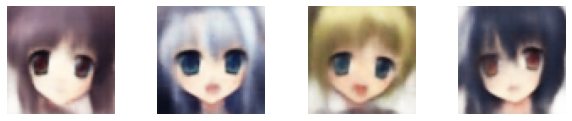

Epoch 171/180
1987/1986 [==============================] - 40s 20ms/step - loss: 289.2215 - r_loss: 0.0225 - kl_loss: 63.7976

Epoch 00171: saving model to ./weights/VAE/weights.h5
Epoch 172/180
1987/1986 [==============================] - 40s 20ms/step - loss: 289.1654 - r_loss: 0.0225 - kl_loss: 63.7614

Epoch 00172: saving model to ./weights/VAE/weights.h5
Epoch 173/180
1987/1986 [==============================] - 40s 20ms/step - loss: 289.1834 - r_loss: 0.0225 - kl_loss: 63.7515

Epoch 00173: saving model to ./weights/VAE/weights.h5
Epoch 174/180
1987/1986 [==============================] - 40s 20ms/step - loss: 289.2011 - r_loss: 0.0225 - kl_loss: 63.7944

Epoch 00174: saving model to ./weights/VAE/weights.h5
Epoch 175/180
1987/1986 [==============================] - 41s 20ms/step - loss: 289.1808 - r_loss: 0.0225 - kl_loss: 63.8181

Epoch 00175: saving model to ./weights/VAE/weights.h5
Epoch 176/180
1987/1986 [==============================] - 40s 20ms/step - loss: 289.2287 - r_l

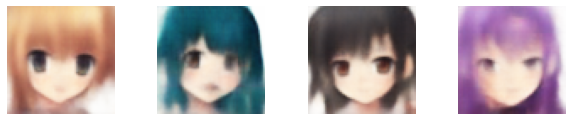

Epoch 181/190
1987/1986 [==============================] - 41s 20ms/step - loss: 289.1284 - r_loss: 0.0225 - kl_loss: 63.7689

Epoch 00181: saving model to ./weights/VAE/weights.h5
Epoch 182/190
1987/1986 [==============================] - 41s 20ms/step - loss: 289.1789 - r_loss: 0.0225 - kl_loss: 63.8539

Epoch 00182: saving model to ./weights/VAE/weights.h5
Epoch 183/190
1987/1986 [==============================] - 41s 20ms/step - loss: 289.0987 - r_loss: 0.0225 - kl_loss: 63.7833

Epoch 00183: saving model to ./weights/VAE/weights.h5
Epoch 184/190
1987/1986 [==============================] - 40s 20ms/step - loss: 289.1075 - r_loss: 0.0225 - kl_loss: 63.8328

Epoch 00184: saving model to ./weights/VAE/weights.h5
Epoch 185/190
1987/1986 [==============================] - 40s 20ms/step - loss: 289.1308 - r_loss: 0.0225 - kl_loss: 63.8392

Epoch 00185: saving model to ./weights/VAE/weights.h5
Epoch 186/190
1987/1986 [==============================] - 40s 20ms/step - loss: 289.0669 - r_l

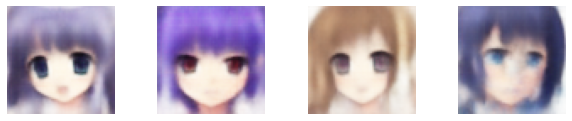

Epoch 191/200
1987/1986 [==============================] - 40s 20ms/step - loss: 289.0079 - r_loss: 0.0225 - kl_loss: 63.8157

Epoch 00191: saving model to ./weights/VAE/weights.h5
Epoch 192/200
1987/1986 [==============================] - 40s 20ms/step - loss: 289.0114 - r_loss: 0.0225 - kl_loss: 63.7982

Epoch 00192: saving model to ./weights/VAE/weights.h5
Epoch 193/200
1987/1986 [==============================] - 40s 20ms/step - loss: 289.0558 - r_loss: 0.0225 - kl_loss: 63.8676

Epoch 00193: saving model to ./weights/VAE/weights.h5
Epoch 194/200
1987/1986 [==============================] - 40s 20ms/step - loss: 289.0218 - r_loss: 0.0225 - kl_loss: 63.8082

Epoch 00194: saving model to ./weights/VAE/weights.h5
Epoch 195/200
1987/1986 [==============================] - 40s 20ms/step - loss: 289.0321 - r_loss: 0.0225 - kl_loss: 63.8159

Epoch 00195: saving model to ./weights/VAE/weights.h5
Epoch 196/200
1987/1986 [==============================] - 41s 21ms/step - loss: 289.0645 - r_l

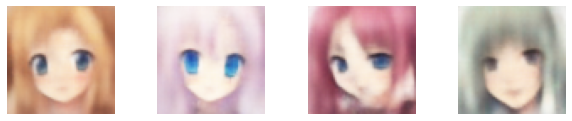

In [0]:
start_list = [i for i in range(0,191,10)]
stop_list = [i for i in range(10,201,10)]
for start, stop in zip(start_list ,stop_list):
  vae_model.fit_generator(data_flow, 
                          shuffle=True, 
                          epochs = stop, 
                          initial_epoch = start, 
                          steps_per_epoch=NUM_IMAGES / BATCH_SIZE,
                          callbacks=[checkpoint_vae])
  vae_generate_images(n_to_show=4)

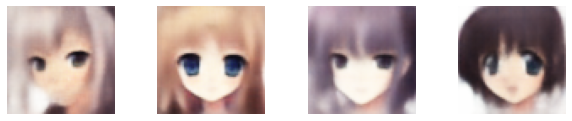

In [0]:
vae_generate_images(n_to_show=4)